In [1]:
!pip install fastai2 kornia nbdev > /dev/null

In [2]:
from fastai2.vision.all import *

# hyperparameters and settings

In [3]:
SEED = 43
ARCHITECTURE = resnet50
AUGMENTATIONS = aug_transforms()
RESOLUTION = 448  # pixels
EPOCHS = 17        # nr of epochs
BS = 32

LBL_COV = 'COVID'
LBL_PATHO = 'Non-COVID'

In [4]:
def set_random_seed(seed):
    import torch

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    # plus:
    # call DataLoader() with worker_init_fn=_init_fn
    # where:
    # def _init_fn(worker_id):
    #   np.random.seed(seed)

In [5]:
path_data = Path('../input/archive2/')

In [6]:
fnames = get_image_files(path_data)
fnames

(#6778) [Path('../input/archive2/valid/C/1625.jpeg'),Path('../input/archive2/valid/C/Screenshot 2020-04-12 at 22.13.47.png'),Path('../input/archive2/valid/C/Parenchyme.0164.jpg'),Path('../input/archive2/valid/C/Parenchyme.0127.jpg'),Path('../input/archive2/valid/C/1661.jpeg'),Path('../input/archive2/valid/C/11343.jpeg'),Path('../input/archive2/valid/C/1691.jpeg'),Path('../input/archive2/valid/C/Screenshot 2020-04-12 at 23.15.48.png'),Path('../input/archive2/valid/C/Screenshot 2020-04-13 at 07.21.38.png'),Path('../input/archive2/valid/C/Screenshot 2020-04-12 at 21.27.18.png')...]

In [7]:
def get_lbl(fname):
    lbl = fname.parent.name
    if lbl == 'P':
        return LBL_PATHO
    elif lbl == 'C':
        return LBL_COV
    else:
        raise ValueError(f'could not extract label from {fname}')
        
def in_valid(fname):
    return fname.parent.parent.name == 'valid'

In [8]:
Counter(fnames.map(get_lbl))

Counter({'COVID': 3057, 'Non-COVID': 3721})

In [9]:
fnames_valid = L([f for f in fnames if in_valid(f)])
fnames_valid

(#1298) [Path('../input/archive2/valid/C/1625.jpeg'),Path('../input/archive2/valid/C/Screenshot 2020-04-12 at 22.13.47.png'),Path('../input/archive2/valid/C/Parenchyme.0164.jpg'),Path('../input/archive2/valid/C/Parenchyme.0127.jpg'),Path('../input/archive2/valid/C/1661.jpeg'),Path('../input/archive2/valid/C/11343.jpeg'),Path('../input/archive2/valid/C/1691.jpeg'),Path('../input/archive2/valid/C/Screenshot 2020-04-12 at 23.15.48.png'),Path('../input/archive2/valid/C/Screenshot 2020-04-13 at 07.21.38.png'),Path('../input/archive2/valid/C/Screenshot 2020-04-12 at 21.27.18.png')...]

In [10]:
Counter(fnames_valid.map(get_lbl))

Counter({'COVID': 592, 'Non-COVID': 706})

In [11]:
fnames_train = L([f for f in fnames if not in_valid(f)])
fnames_train

(#5480) [Path('../input/archive2/train/C/497.jpeg'),Path('../input/archive2/train/C/1251.jpeg'),Path('../input/archive2/train/C/40.png'),Path('../input/archive2/train/C/1537.jpeg'),Path('../input/archive2/train/C/Screenshot 2020-04-13 at 06.48.45.png'),Path('../input/archive2/train/C/113.jpeg'),Path('../input/archive2/train/C/Screenshot 2020-04-12 at 22.04.41.png'),Path('../input/archive2/train/C/1292.jpeg'),Path('../input/archive2/train/C/960.jpeg'),Path('../input/archive2/train/C/Screenshot 2020-04-12 at 21.55.04.png')...]

In [12]:
Counter(fnames_train.map(get_lbl))

Counter({'COVID': 2465, 'Non-COVID': 3015})

In [13]:
set_random_seed(SEED)

db = DataBlock(get_items=get_image_files,
               get_y=get_lbl,
               item_tfms=Resize(RESOLUTION),
               blocks=(ImageBlock, CategoryBlock),
               splitter=FuncSplitter(in_valid),
               batch_tfms=AUGMENTATIONS #aug_transforms() #max_lighting=0.1, max_warp=0.1, p_lighting=0.1
              )

In [14]:
dls = db.dataloaders(path_data, bs=BS)

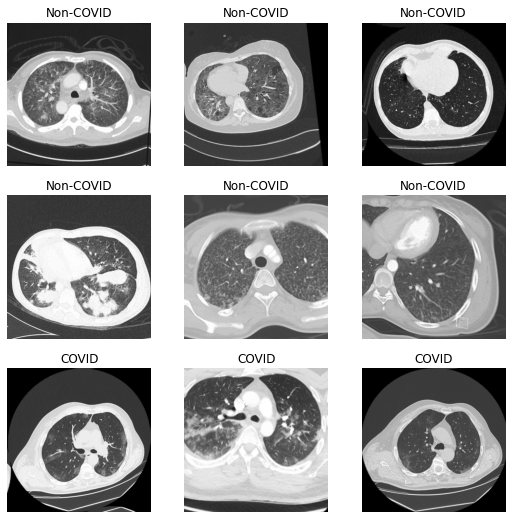

In [15]:
dls.show_batch()#unique=True)

In [16]:
learn = cnn_learner(dls, ARCHITECTURE, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [18]:
learn.fine_tune(EPOCHS)

epoch,train_loss,valid_loss,accuracy,time
0,0.378609,0.525361,0.837442,03:22


epoch,train_loss,valid_loss,accuracy,time
0,0.098471,0.457220,0.909091,03:29
1,0.076012,0.512412,0.889060,03:28
2,0.062074,0.672105,0.875193,03:30
3,0.095865,0.630591,0.842065,03:27
4,0.062492,0.964691,0.830508,03:31
5,0.041371,0.536683,0.901387,03:27
6,0.035115,0.444760,0.873652,03:28
7,0.036081,0.378646,0.891371,03:28
8,0.022893,0.592873,0.881356,03:29
9,0.023926,0.360490,0.908320,03:28


In [35]:
learn.save('v0.1')

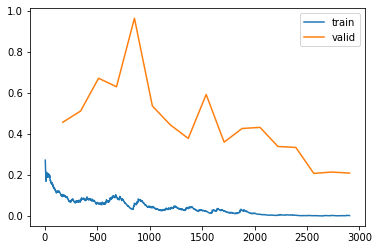

In [21]:
learn.recorder.plot_loss()

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

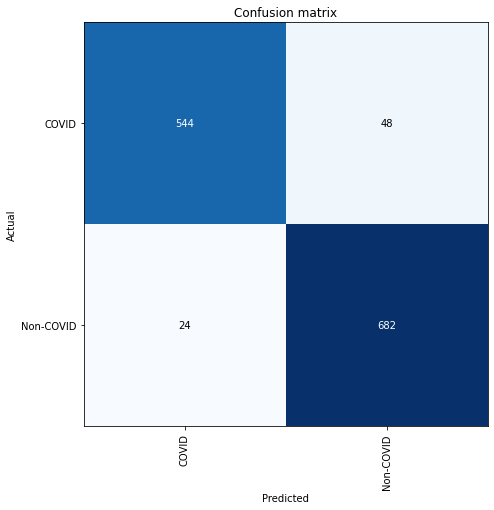

In [23]:
interp.plot_confusion_matrix(figsize=(7, 7))

In [50]:
interp.print_classification_report()

              precision    recall  f1-score   support

       COVID       0.96      0.92      0.94       592
   Non-COVID       0.93      0.97      0.95       706

    accuracy                           0.94      1298
   macro avg       0.95      0.94      0.94      1298
weighted avg       0.94      0.94      0.94      1298



In [36]:
learn.export('rn50-448px-v0.8-export.pkl')

# comparing with a testset
this avoids one source of human bias, which is using the validation set as metric to decide which model to use

In [25]:
path_test = Path('../input/test3/test3')

In [26]:
fnames_test = get_image_files(path_test)
fnames_test

(#90) [Path('../input/test3/test3/C/11385.jpeg'),Path('../input/test3/test3/C/11379.jpeg'),Path('../input/test3/test3/C/11755.jpeg'),Path('../input/test3/test3/C/11748.jpeg'),Path('../input/test3/test3/C/11753.jpeg'),Path('../input/test3/test3/C/11394.jpeg'),Path('../input/test3/test3/C/Screenshot 2020-04-19 at 20.46.25.png'),Path('../input/test3/test3/C/11368.jpeg'),Path('../input/test3/test3/C/11745.jpeg'),Path('../input/test3/test3/C/Screenshot 2020-04-19 at 20.46.41.png')...]

In [27]:
def get_stats_any(cls_of_interest, list_of_imgs, learner=learn):
    TP = [] # true positive
    TN = [] # true negative
    FP = [] # false positive
    FN = [] # false negative
    for img in list_of_imgs:
        result = learner.predict(img)
        predicted = result[0]
        label = get_lbl(img)
        res = f(predicted, label, cls_of_interest)
        if res == 'TP':
            TP.append(img)
        elif res == 'TN':
            TN.append(img)
        elif res == 'FP':
            FP.append(img)
        elif res == 'FN':
            FN.append(img)
        else:
            raise ValueError(str(res))
    return (TP, TN, FP, FN)
        
def f(predicted, label, cls_of_interest):
    if predicted == label == cls_of_interest:
        return 'TP'
    elif predicted == label != cls_of_interest:
        return 'TN'
    elif predicted == cls_of_interest:
        return 'FP'
    elif label == cls_of_interest:
        return 'FN'
    else:
        raise ValueError(f'predicted: {predicted}, label: {label}, cls_of_interest:{cls_of_interest}')


In [28]:
def get_sensitivity(TP, TN, FP, FN):
    return TP/(TP+FN)

def get_specificity(TP, TN, FP, FN):
    return TN/(TN+FP)

def get_precision(TP, TN, FP, FN):
    return TP/(TP+FP)
    
def get_negative_predictive_value(TP, TN, FP, FN):
    return TN/(TN+FN)
    
def get_accuracy(TP, TN, FP, FN):
    return (TP+TN)/(TP+FP+FN+TN)

In [29]:
def print_stats(TP, TN, FP, FN, cls):
    print('stats for', cls)
    print('=' * 40)
    print(f'sensitivity: {get_sensitivity(TP, TN, FP, FN)}')
    print(f'specificity: {get_specificity(TP, TN, FP, FN)}')
    print(f'precision: {get_precision(TP, TN, FP, FN)}')
    print(f'negative predictive value: {get_negative_predictive_value(TP, TN, FP, FN)}')
    print(f'accuracy: {get_accuracy(TP, TN, FP, FN)}')

In [30]:
def get_stats_cov(list_of_imgs):
    return get_stats_any(LBL_COV, list_of_imgs)

In [31]:
TP_C, TN_C, FP_C, FN_C = get_stats_cov(fnames_test)

In [38]:
args = list(map(len, [TP_C, TN_C, FP_C, FN_C]))
print(f'true positive: {len(TP_C)}, true negative: {len(TN_C)}')
print(f'false positive: {len(FP_C)}, false negative: {len(FN_C)}')

true positive: 38, true negative: 42
false positive: 3, false negative: 7


In [33]:
print_stats(*args, 'COVID')

stats for COVID
sensitivity: 0.8444444444444444
specificity: 0.9333333333333333
precision: 0.926829268292683
negative predictive value: 0.8571428571428571
accuracy: 0.8888888888888888


In [34]:
Counter(fnames_test.map(get_lbl))

Counter({'COVID': 45, 'Non-COVID': 45})